In [1]:
from tempfile import TemporaryDirectory

import mlflow
import mlflow.artifacts
import numpy as np
import pandas as pd

import cate.dataset as cds
from cate.infra.mlflow import REMOTE_TRACKING_URI
from cate.utils import path_linker


In [2]:
mlflow.set_tracking_uri(REMOTE_TRACKING_URI)

In [3]:
stats = {}

In [4]:
dataset_names = ("criteo", "hillstorm", "lenta", "megafon")
ds_list = [cds.Dataset.load(path_linker(name).mart) for name in dataset_names]

In [5]:
stats["count"] = [len(ds) for ds in ds_list]
stats["explanatory_count"] = [ds.X.shape[1] for ds in ds_list]
stats["conversion_rate"] = [np.mean(ds.y) for ds in ds_list]
stats["tg_rate"] = [np.mean(ds.w) for ds in ds_list]

In [6]:
ates = []
for ds in ds_list:
    ate = np.mean(ds.y[ds.w == 1]) - np.mean(ds.y[ds.w == 0])
    ates.append(ate)
stats["ate"] = ates

In [7]:
df = pd.DataFrame(stats, index=dataset_names)

In [8]:
run_ids = [
    "43672a60028541aca258a276de5b80d4",
    "8d77d119af6e4c9f820e9dd564b76620",
    "c3ca1d7631524ef99b578cdf84133bf9",
      "c2ecc90d9d99484ba4d920578bf612f8",
]

In [9]:
metrics_df = pd.DataFrame(
    [mlflow.get_run(run_id).data.metrics for run_id in run_ids],
    index=[mlflow.get_run(run_id).data.tags["dataset"] for run_id in run_ids],
)

In [10]:
df = pd.concat([df, metrics_df], axis=1)

In [11]:
df

,count,explanatory_count,conversion_rate,tg_rate,ate,accuracy,auuc,f1,precision,qini_at_0,...,uplift_at_10,uplift_at_100,uplift_at_20,uplift_at_30,uplift_at_40,uplift_at_50,uplift_at_60,uplift_at_70,uplift_at_80,uplift_at_90
criteo,13979592,12,0.002917,0.850000,0.001152,0.996983,0.022502,0.148916,0.420082,0.0,...,0.008099,0.001152,0.004818,0.003427,0.002650,0.002164,0.001816,0.001557,0.001362,0.001216
hillstorm,64000,12,0.009031,0.667094,0.004955,0.990953,0.027119,0.000000,0.000000,0.0,...,0.006971,0.004955,0.006529,0.004975,0.004978,0.004922,0.004581,0.004693,0.004590,0.004699
lenta,687029,195,0.108246,0.750903,0.007547,0.897426,0.052232,0.215359,0.626157,0.0,...,0.008072,0.007547,0.009561,0.010369,0.010199,0.009978,0.009101,0.008741,0.008339,0.008061
megafon,600000,50,0.204190,0.500613,0.049519,0.824510,0.612967,0.311210,0.783653,0.0,...,0.050159,0.049519,0.111955,0.112237,0.106464,0.101118,0.095894,0.089361,0.080046,0.063808


In [12]:
df.to_csv("/workspace/output/datasets_stats/base_stats.csv")


<Axes: >

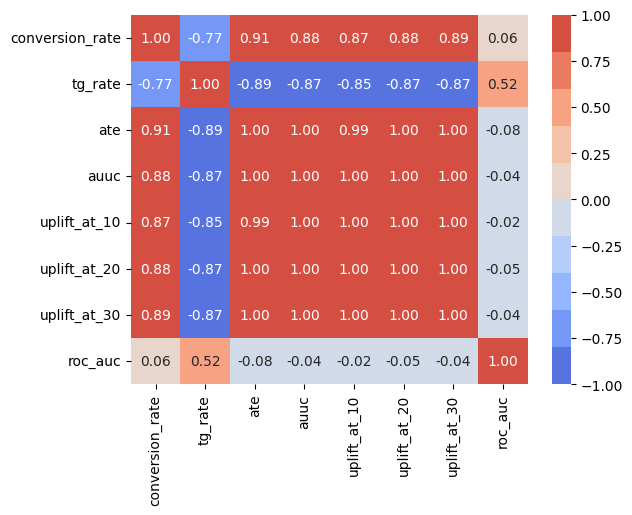

In [16]:
import seaborn as sns

cor = df.loc[
    :,
    [
        "conversion_rate",
        "tg_rate",
        "ate",
        "auuc",
        "uplift_at_10",
        "uplift_at_20",
        "uplift_at_30",
        "roc_auc",
    ],
].corr()
sns.heatmap(
    cor, cmap=sns.color_palette("coolwarm", 10), annot=True, fmt=".2f", vmin=-1, vmax=1
)
